## Análise de Sinais e Vibração com FFT

**Objetivo:** Utilizar a Transformada Rápida de Fourier (FFT) para analisar sinais de vibração e detectar falhas em um motor elétrico.

**Contexto:** Máquinas rotativas, como motores, bombas e compressores, geram padrões de vibração durante sua operação. Um motor saudável vibra de uma maneira previsível, dominada pela sua frequência de rotação. No entanto, falhas mecânicas como **desalinhamento, desbalanceamento, folgas ou desgaste de rolamentos** introduzem novas vibrações em frequências características. 

**Por que FFT?**
Um sensor de vibração (acelerômetro) nos dá um sinal no **domínio do tempo** (amplitude vs. tempo). Olhar para este sinal bruto pode ser confuso e muitas vezes não revela a falha subjacente. A **FFT** é uma ferramenta matemática que decompõe este sinal complexo em suas frequências constituintes, mostrando-nos o **domínio da frequência** (amplitude vs. frequência). É neste domínio que as "assinaturas" das falhas se tornam claras.

**Cenário:** Vamos analisar três casos para um motor que opera a 60 Hz (3600 RPM):
1.  **Motor Saudável:** Vibração concentrada em 60 Hz.
2.  **Motor com Desalinhamento:** Vibração forte em 2x a frequência de rotação (120 Hz).
3.  **Motor com Desgaste de Rolamento:** Vibração em uma frequência mais alta e não relacionada diretamente à rotação.

### Configuração e Importação de Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq

# Configurações de visualização
plt.rcParams["figure.figsize"] = (16, 6)

### Simulação dos Sinais de Vibração

Primeiro, vamos definir os parâmetros da nossa simulação e gerar os sinais no domínio do tempo.

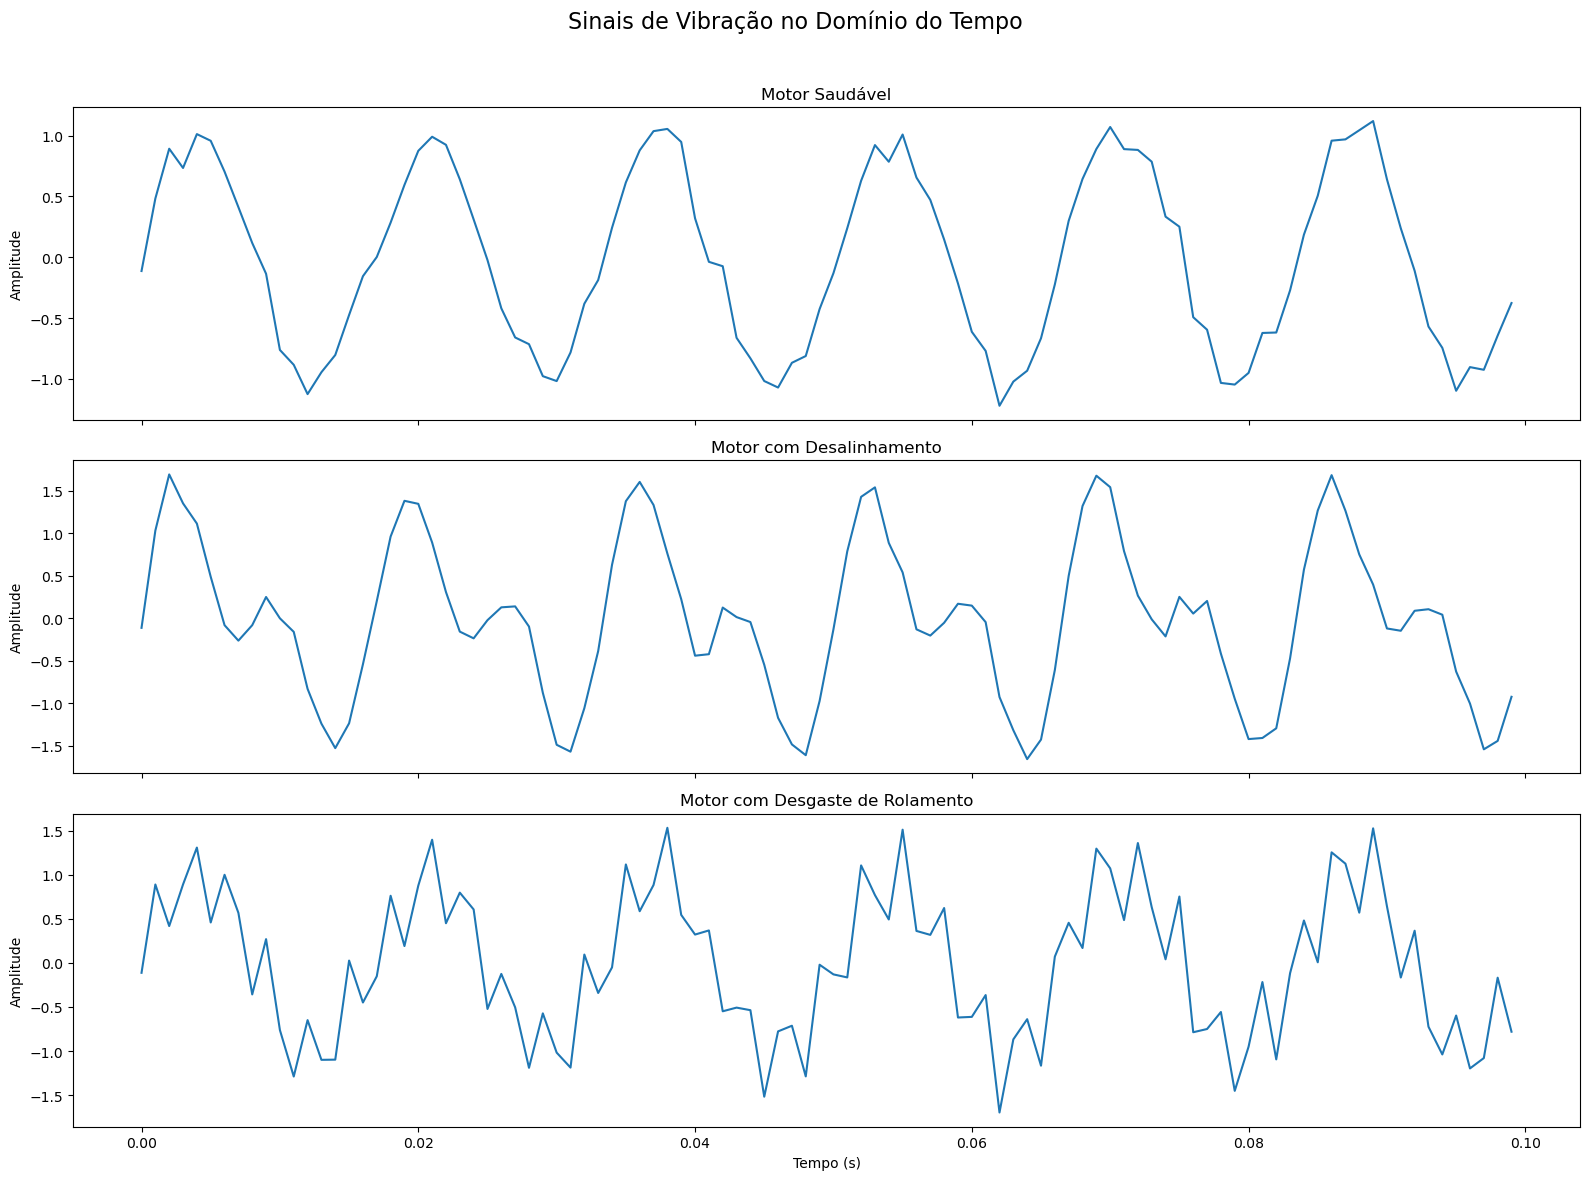

In [2]:
# Parâmetros da Simulação
SAMPLING_RATE = (
    1000  # Frequência de amostragem (Hz), deve ser > 2x a maior frequência de interesse
)
DURATION = 5  # Duração do sinal em segundos
N_SAMPLES = SAMPLING_RATE * DURATION

# Frequência de rotação do motor
F_MOTOR = 60  # Hz

# Gera o vetor de tempo
t = np.linspace(0.0, DURATION, N_SAMPLES, endpoint=False)

# --- Geração dos Sinais ---

# 1. Motor Saudável
# Sinal é uma senoide na frequência do motor + um pouco de ruído branco.
noise = np.random.randn(N_SAMPLES) * 0.1
signal_healthy = 1.0 * np.sin(2 * np.pi * F_MOTOR * t) + noise

# 2. Motor com Desalinhamento
# Adiciona uma componente forte em 2x a frequência do motor.
f_misalignment = 2 * F_MOTOR
signal_misaligned = signal_healthy + 0.8 * np.sin(2 * np.pi * f_misalignment * t)

# 3. Motor com Desgaste de Rolamento
# Adiciona uma componente em uma frequência mais alta.
f_bearing = 350  # Hz, uma frequência típica de falha de rolamento
signal_bearing_wear = signal_healthy + 0.5 * np.sin(2 * np.pi * f_bearing * t)

# --- Visualização no Domínio do Tempo ---
fig, axs = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle("Sinais de Vibração no Domínio do Tempo", fontsize=16)

# Plota uma pequena fatia do tempo para ver a forma da onda
slice_end = int(0.1 * SAMPLING_RATE)  # Primeiros 0.1 segundos

axs[0].plot(t[:slice_end], signal_healthy[:slice_end])
axs[0].set_title("Motor Saudável")
axs[0].set_ylabel("Amplitude")

axs[1].plot(t[:slice_end], signal_misaligned[:slice_end])
axs[1].set_title("Motor com Desalinhamento")
axs[1].set_ylabel("Amplitude")

axs[2].plot(t[:slice_end], signal_bearing_wear[:slice_end])
axs[2].set_title("Motor com Desgaste de Rolamento")
axs[2].set_ylabel("Amplitude")
axs[2].set_xlabel("Tempo (s)")

plt.tight_layout(rect=[0, 0, 1, 0.96])

**Observação:** Olhando para as ondas acima, podemos notar diferenças, mas é muito difícil diagnosticar o problema específico com confiança. Agora, vamos aplicar a FFT.

### Análise no Domínio da Frequência com FFT

Vamos criar uma função para aplicar a FFT e plotar o espectro de frequência. O espectro nos mostrará quais frequências estão presentes no sinal e qual a sua intensidade (amplitude).

In [3]:
def plot_fft(signal, title):
    """Calcula e plota o espectro de frequência de um sinal."""

    # Calcula a FFT
    yf = fft(signal)
    xf = fftfreq(N_SAMPLES, 1 / SAMPLING_RATE)

    # Pega apenas a parte positiva do espectro e normaliza
    mask = xf >= 0
    xf_pos = xf[mask]
    yf_pos = 2.0 / N_SAMPLES * np.abs(yf[mask])

    # Plota o Espectro de Frequência
    plt.figure(figsize=(16, 6))
    plt.plot(xf_pos, yf_pos)
    plt.title(f"Espectro de Frequência - {title}", fontsize=16)
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, SAMPLING_RATE / 2)  # Limita o eixo X até a frequência de Nyquist

    return xf_pos, yf_pos

#### 1 Espectro do Motor Saudável

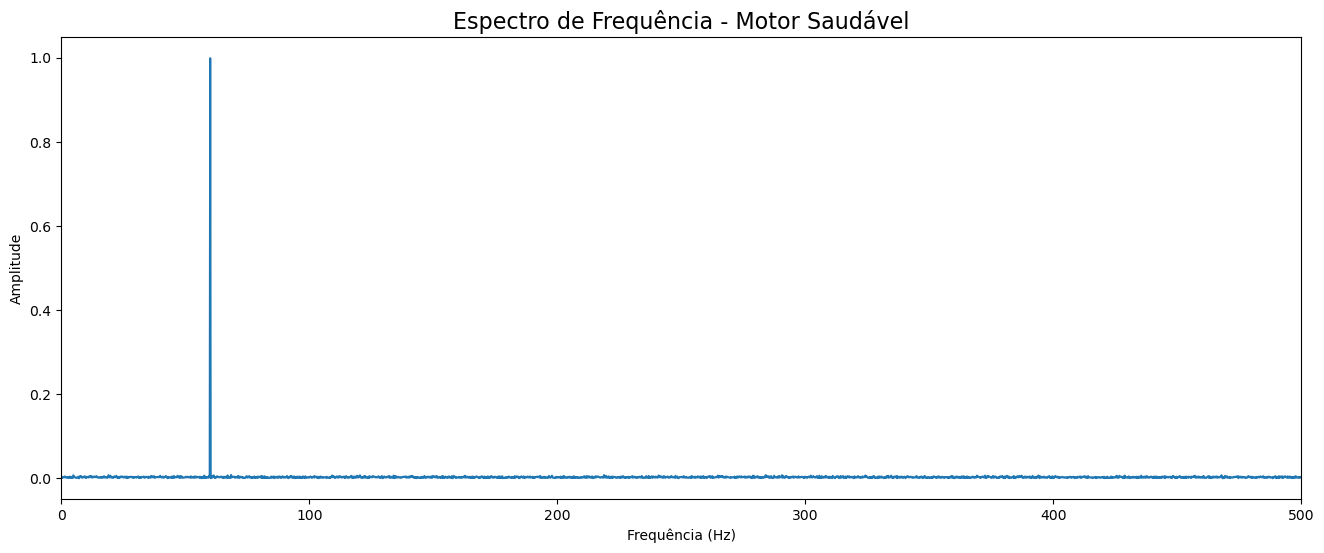

In [4]:
xf_healthy, yf_healthy = plot_fft(signal_healthy, "Motor Saudável")

**Diagnóstico:** Como esperado, vemos um único pico proeminente exatamente em **60 Hz**. Esta é a assinatura de um motor saudável operando normalmente.

#### 2 Espectro do Motor com Desalinhamento

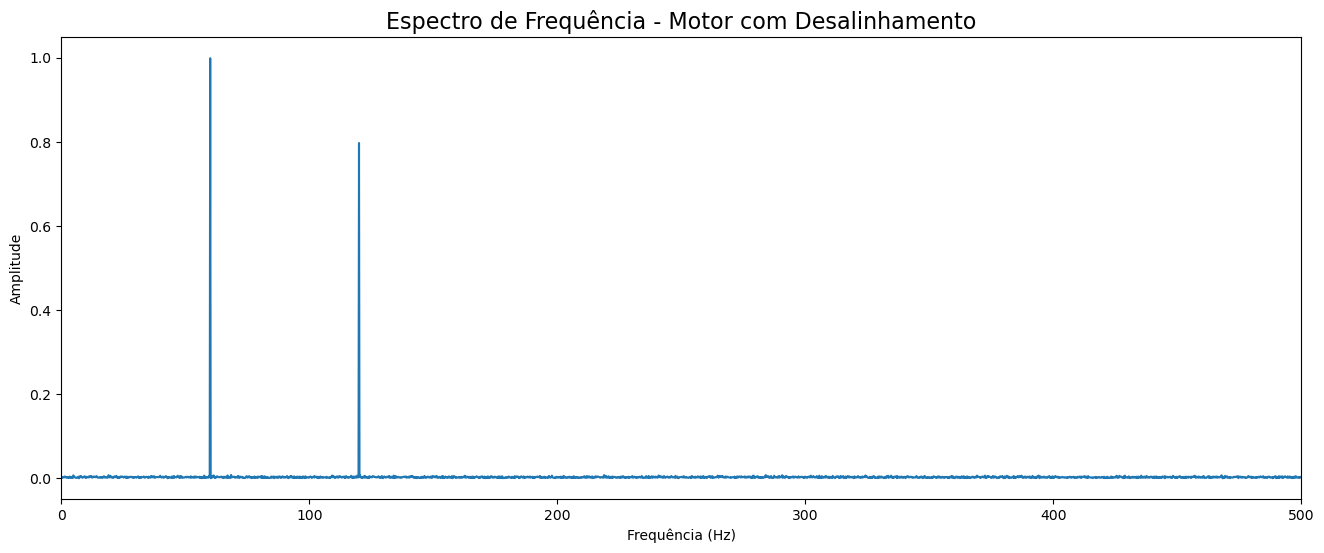

In [5]:
xf_misaligned, yf_misaligned = plot_fft(signal_misaligned, "Motor com Desalinhamento")

**Diagnóstico:** O diagnóstico aqui é claro! Além do pico normal em 60 Hz, agora temos um segundo pico muito forte em **120 Hz**. Essa assinatura (pico em 2x a frequência de rotação) é um indicador clássico de **desalinhamento** entre o motor e a carga que ele aciona.

#### 3 Espectro do Motor com Desgaste de Rolamento

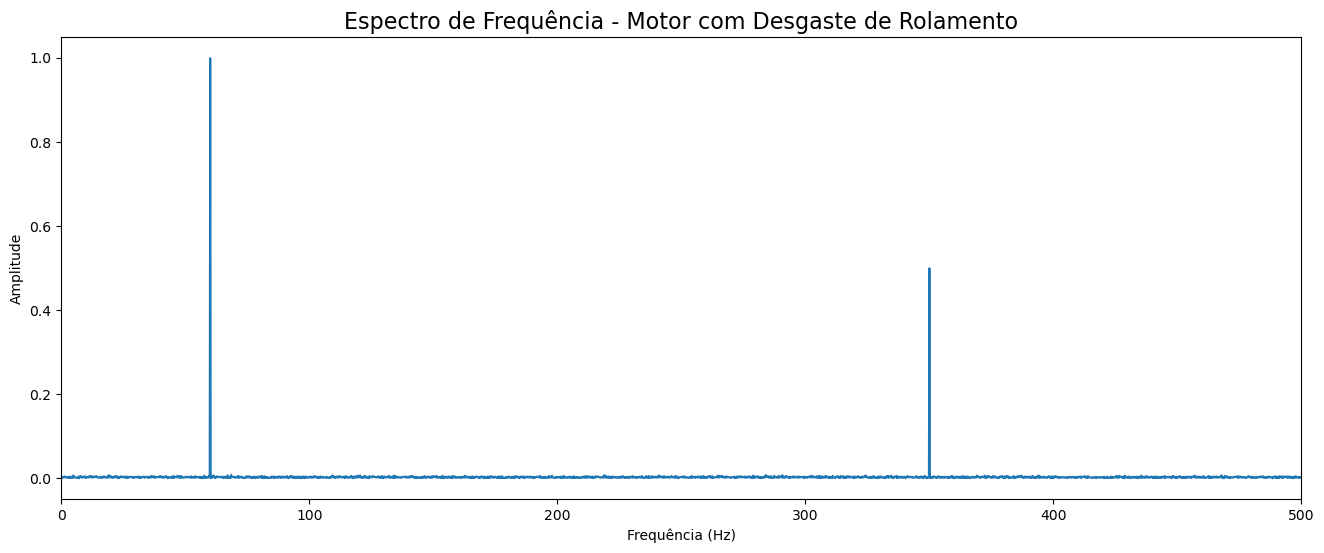

In [6]:
xf_bearing, yf_bearing = plot_fft(
    signal_bearing_wear, "Motor com Desgaste de Rolamento"
)

**Diagnóstico:** Neste espectro, além do pico de 60 Hz, vemos uma nova vibração de amplitude considerável em **350 Hz**. Vibrações em altas frequências que não são múltiplos diretos da rotação (harmônicos) são frequentemente associadas a defeitos nos **rolamentos**.

### Automatizando o Diagnóstico

Podemos transformar essa análise visual em um sistema de diagnóstico automatizado. A função abaixo procura por picos de alta energia nas frequências características de cada falha.

In [7]:
def diagnose_vibration(xf, yf, f_motor, threshold=0.3):
    """Analisa um espectro de frequência e retorna um diagnóstico simples."""

    # Procura por pico de desalinhamento (2x F_MOTOR)
    freq_misalignment = 2 * f_motor
    # Pega o índice mais próximo da frequência de interesse
    idx_misalignment = np.argmin(np.abs(xf - freq_misalignment))
    amp_misalignment = yf[idx_misalignment]

    if amp_misalignment > threshold:
        return f"Falha Detectada: Possível DESALINHAMENTO (pico de {amp_misalignment:.2f} em {xf[idx_misalignment]:.1f} Hz)"

    # Procura por picos de alta frequência (rolamentos)
    # Consideramos 'alta frequência' como > 3x F_MOTOR
    high_freq_mask = xf > 3 * f_motor
    if np.any(yf[high_freq_mask] > threshold):
        # Encontra a frequência exata do pico mais alto na região de alta frequência
        max_amp_hf = np.max(yf[high_freq_mask])
        max_freq_hf = xf[high_freq_mask][np.argmax(yf[high_freq_mask])]
        return f"Falha Detectada: Possível DESGASTE DE ROLAMENTO (pico de {max_amp_hf:.2f} em {max_freq_hf:.1f} Hz)"

    return "Condição Saudável: Nenhuma falha óbvia detectada."


# Executando o diagnóstico para cada caso
diag_healthy = diagnose_vibration(xf_healthy, yf_healthy, F_MOTOR)
diag_misaligned = diagnose_vibration(xf_misaligned, yf_misaligned, F_MOTOR)
diag_bearing = diagnose_vibration(xf_bearing, yf_bearing, F_MOTOR)

print(f"Diagnóstico do Motor 1: {diag_healthy}")
print(f"Diagnóstico do Motor 2: {diag_misaligned}")
print(f"Diagnóstico do Motor 3: {diag_bearing}")

Diagnóstico do Motor 1: Condição Saudável: Nenhuma falha óbvia detectada.
Diagnóstico do Motor 2: Falha Detectada: Possível DESALINHAMENTO (pico de 0.80 em 120.0 Hz)
Diagnóstico do Motor 3: Falha Detectada: Possível DESGASTE DE ROLAMENTO (pico de 0.50 em 350.0 Hz)


### Conclusão

Este notebook demonstrou o poder da Transformada Rápida de Fourier (FFT) como uma ferramenta essencial para a Manutenção Preditiva baseada em condição.

1.  **Transformação de Dados:** A FFT converte sinais de vibração complexos do domínio do tempo para um espectro de frequência muito mais interpretável.
2.  **Identificação de Assinaturas:** Diferentes falhas mecânicas (desalinhamento, desgaste de rolamento, etc.) possuem "assinaturas" ou "impressões digitais" únicas no domínio da frequência.
3.  **Detecção Precoce:** Ao monitorar o espectro de frequência de uma máquina ao longo do tempo, podemos detectar o surgimento de picos anômalos muito antes que a falha se torne catastrófica, permitindo um planejamento de manutenção proativo.

Esta técnica é a base para sistemas de monitoramento de condição em toda a indústria, ajudando a aumentar a confiabilidade, segurança e eficiência dos ativos.